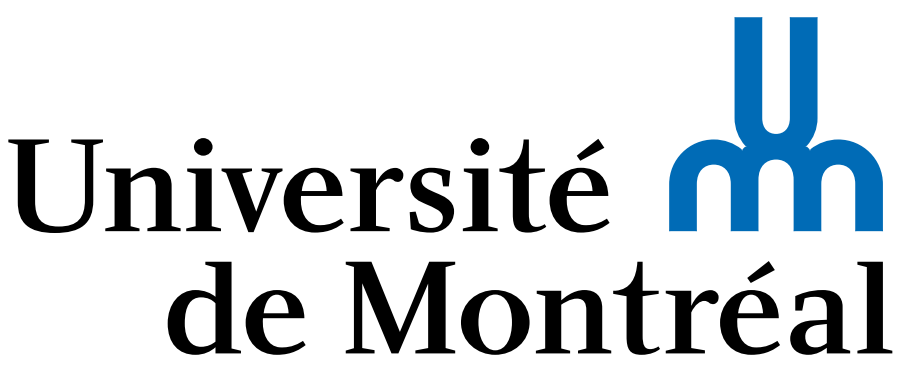

# IFT6285 (TALN) 

## Devoir 2: Modèles n-grammes avec kenlm

Réalisé par:

Mouna Dhaouadi 

Kacem Khaled

Soumis à:

Prof. Philippe Langlais

Frédéric Piedboeuf


**Automne 2021**

In [ ]:
pip install https://github.com/kpu/kenlm/archive/master.zip

In [ ]:
!pip install clean-text

In [1]:
import kenlm
import time
from tqdm import tqdm
import os
from os import listdir
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean
from cleantext import clean

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [2]:
folder = 'training-monolingual.tokenized.shuffled/'
folder_short = '1bshort/'
folder_test = 'heldout-monolingual.tokenized.shuffled/'
kenlm_dir = '/home/kacem/kenlm/' 
test_file = folder_test+'news.en-00000-of-00100'
model_file = 'models/bigram'

In [3]:
# make sure we are in the right directory 
a  = subprocess.run('pwd',  capture_output=True,text=True)
print(a.stdout)

/mnt/c/Users/kacem/Workspace/IFT6285/github-nlp/IFT6285-NLP/TP2



In [4]:
def test(model_file, folder_test):
    model = kenlm.Model(model_file)
    perplex = []
    i=0
    test_file = listdir(folder_test)[0]
    with open(folder_test+test_file, 'r',encoding="utf8") as f:
        while i < 1000:
            line = f.readline()
            perplex.append(model.perplexity(line))
            i+=1
    f.close()
    return perplex

In [5]:
def preprocess(folder):
    # creates a folder called 'pre-processed' inside the folder given as input 
    # Pre-preocesses all the files inside the input folder
    # Saves the pre-processed files iside the new created folder 
    
    print("Pre-processing files in :",folder)
    print("""lower=True, no_numbers=False, replace_with_number="__NUM__",
             no_urls=True, replace_with_url="__URL__",
             no_emails=True, replace_with_email="__EMAIL__""""")
    path = folder[:-1]+'-pre-processed/'
    
    if not os.path.exists(path):
        os.mkdir(path)
    
    files = listdir(folder)
    for fn in tqdm(files):
        with open(folder+fn, 'r',encoding="utf8") as f:
            corpus = f.read()
            corpus = clean(corpus,fix_unicode=False,to_ascii = False,
                            lower=True, 
                           no_numbers=True, replace_with_number="__NUM__", 
                           no_urls=True, replace_with_url="__URL__",
                           no_emails=True, replace_with_email="__EMAIL__")
        fn_preprecessed = open(path+fn, "w")
        fn_preprecessed.write(corpus)
        fn_preprecessed.close()
        f.close()
    print("Files saved at the folder: ",path)
    return path

In [6]:
folder_preprocess = preprocess(folder_short)

  0%|          | 0/9 [00:00<?, ?it/s]

Pre-processing files in : 1bshort/
lower=True, no_numbers=False, replace_with_number="__NUM__",
             no_urls=True, replace_with_url="__URL__",
             no_emails=True, replace_with_email="__EMAIL__


100%|██████████| 9/9 [02:03<00:00, 13.77s/it]

Files saved at the folder:  1bshort-pre-processed/


In [7]:
test_preprocess = preprocess(folder_test)

  0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing files in : heldout-monolingual.tokenized.shuffled/
lower=True, no_numbers=False, replace_with_number="__NUM__",
             no_urls=True, replace_with_url="__URL__",
             no_emails=True, replace_with_email="__EMAIL__


100%|██████████| 1/1 [00:13<00:00, 13.60s/it]

Files saved at the folder:  heldout-monolingual.tokenized.shuffled-pre-processed/


In [29]:
def train(model_file, folder,test_folder, order=2, pre_processed = False):
    files = listdir(folder)
    times = []
    sizes = []
    perplexities = []
    training_sample = "models/training_sample.txt" if not pre_processed else "models/training_sample_pre.txt"
    myfile =  open(training_sample, "w")
    myfile.close()
    for i,fn in enumerate(files):
        model_file_name = model_file +str(i+1)+'.arpa'
        # comcatenate the first {0..i} text files and use them all for training
        # this would help check the impact of training data size
        os.system("cat "+folder+fn+ " >> "+ training_sample)
        print(f"Files 1..{i+1}:")
        #print(fns)
        start_time = time.time()
        cmd = kenlm_dir+'build/bin/lmplz -o '+str(order)+' -S 80% -T /tmp < '+training_sample+' > '+model_file_name
        #print(cmd, end='\n\n')
        os.system(cmd)
        t = time.time() - start_time
        size = os.path.getsize(model_file_name) / (1024*1024) # convert to MB
        perp = test(model_file_name,test_folder)
        times.append(t)
        sizes.append(size)
        perplexities.append(perp)
        print(f'Time: {t:.2f}s\t Size: {size:.2f}MB\t Mean(perplexities): {mean(perp):.2f}')
    return times, sizes, perplexities

In [9]:
model_file = 'models/bigram'
times_bi, sizes_bi, perplexities_bi = train(model_file,folder_short,folder_test,2)

Files 1..1:
Time: 4.99s	 Size: 52.29MB	 Mean(perplexities): 519.21
Files 1..2:
Time: 9.47s	 Size: 85.39MB	 Mean(perplexities): 459.77
Files 1..3:
Time: 13.27s	 Size: 112.84MB	 Mean(perplexities): 452.84
Files 1..4:
Time: 16.84s	 Size: 137.61MB	 Mean(perplexities): 445.56
Files 1..5:
Time: 20.82s	 Size: 160.58MB	 Mean(perplexities): 433.43
Files 1..6:
Time: 25.67s	 Size: 181.73MB	 Mean(perplexities): 432.02
Files 1..7:
Time: 29.61s	 Size: 201.99MB	 Mean(perplexities): 418.99
Files 1..8:
Time: 33.52s	 Size: 220.77MB	 Mean(perplexities): 416.19
Files 1..9:
Time: 34.92s	 Size: 239.24MB	 Mean(perplexities): 412.93


In [10]:
model_file = 'models/bigram_p'
times_bi_p, sizes_bi_p, perplexities_bi_p = train(model_file,folder_preprocess,test_preprocess,2, True)

Files 1..1:
Time: 6.39s	 Size: 47.02MB	 Mean(perplexities): 411.12
Files 1..2:
Time: 8.69s	 Size: 76.21MB	 Mean(perplexities): 382.57
Files 1..3:
Time: 12.39s	 Size: 100.75MB	 Mean(perplexities): 375.36
Files 1..4:
Time: 15.79s	 Size: 122.34MB	 Mean(perplexities): 369.00
Files 1..5:
Time: 20.17s	 Size: 142.42MB	 Mean(perplexities): 362.84
Files 1..6:
Time: 23.36s	 Size: 160.11MB	 Mean(perplexities): 358.42
Files 1..7:
Time: 27.13s	 Size: 178.11MB	 Mean(perplexities): 345.74
Files 1..8:
Time: 29.94s	 Size: 194.39MB	 Mean(perplexities): 342.42
Files 1..9:
Time: 34.01s	 Size: 210.24MB	 Mean(perplexities): 339.87


In [ ]:
len(perplexities_bi[0])
min_p = [min(p) for p in perplexities_bi]
max_p = [max(p) for p in perplexities_bi]
avg_p = [mean(p) for p in perplexities_bi]

In [51]:
def plot_curves(times_bi, sizes_bi, perplexities_bi,figname='Bigram'):
    avg_p = [mean(p) for p in perplexities_bi]
    tranches = list(range(1,10))
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(tranches, sizes_bi  , 'g-', label="Taille (MB)")
    ax.set_xlabel("Nombre de tranches considérées")
    ax.set_ylabel("Taille de modèle (MB) | Temps d'entrainement (s)")

    ax.plot(tranches, times_bi,'r-', label="Temps (s)")
    #ax.set_ylabel("Le temps mis pour l'entrainement (en secondes)", color = 'r')

    ax2=ax.twinx()

    ax2.plot(tranches, avg_p,'b-', label="Moyennes perplexité")
    ax2.set_xlabel("Nombre de tranches considérées")
    ax2.set_ylabel("Moyenne des perplexités", color = 'b')

    ax.set_xlim(1, 9)
    #ax.set_ylim(0, 300)
    #ax2.set_ylim(400, 550)

    ax.legend(loc=2)
    ax2.legend(loc=1)
    plt.rcParams.update({'font.size': 10})
    plt.title(figname)

    fig.savefig(figname+".jpg",format="jpg")
    plt.show()

def plot_curves_multiple(times_bi, sizes_bi, perplexities_bi,
                         times_bi_p, sizes_bi_p, perplexities_bi_p,
                         figname='Bigram'):
    avg_p = [mean(p) for p in perplexities_bi]
    avg_p_pr = [mean(p) for p in perplexities_bi_p]
    tranches = list(range(1,10))
    font_size = 12
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.set_xlabel("Nombre de tranches considérées", fontsize=font_size)
    ax.set_ylabel("Taille de modèle (MB) | Temps d'entrainement (s)", fontsize=font_size)
    ax.plot(tranches, sizes_bi  , 'g-', label="Taille (MB)")
    ax.plot(tranches, times_bi,'r-', label="Temps (s)")
    ax.plot(tranches, sizes_bi_p  , 'g--', label="[Pre] Taille (MB)")
    ax.plot(tranches, times_bi_p,'r--', label="[Pre] Temps (s)")
    #ax.set_ylabel("Le temps mis pour l'entrainement (en secondes)", color = 'r')
    ax2=ax.twinx()
    ax2.plot(tranches, avg_p,'b-', label="Moy. perplexité")
    ax2.plot(tranches, avg_p_pr,'b--', label="[Pre] Moy. perplexité")
    ax2.set_xlabel("Nombre de tranches considérées", fontsize=font_size)
    ax2.set_ylabel("Moyenne des perplexités", color = 'b', fontsize=font_size)

    ax.set_xlim(1, 9)
    #ax.set_ylim(0, 300)
    #ax2.set_ylim(400, 550)

    ax.legend(loc=2,prop={"size":11})
    ax2.legend(loc=1,prop={"size":11})
    plt.title(figname)

    fig.savefig(figname+".jpg",format="jpg")
    plt.show()

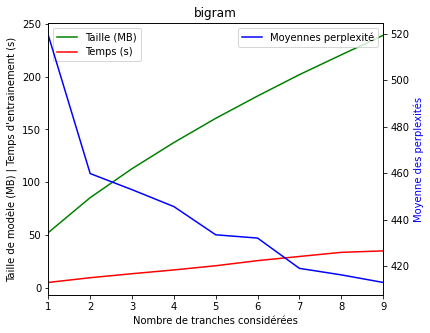

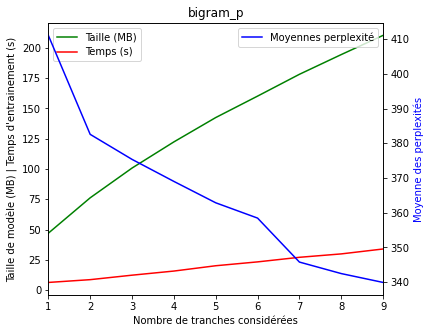

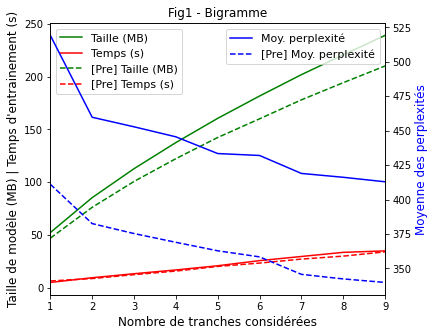

In [56]:
plot_curves(times_bi, sizes_bi, perplexities_bi,'bigram')
plot_curves(times_bi_p, sizes_bi_p, perplexities_bi_p,'bigram_p')
plot_curves_multiple(times_bi, sizes_bi, perplexities_bi,
                         times_bi_p, sizes_bi_p, perplexities_bi_p,
                         figname='Fig1 - Bigramme')

In [30]:
tranches = list(range(1,10))
d = {'Tranches': tranches, 'Tailles des modèles (MB)': sizes_bi, 'Temps d\'entrainement (s)': times_bi, 
     'Perplexité moyenne': [mean(p) for p in perplexities_bi] }
df_results = pd.DataFrame(data=d, index = list(range(1,10)))
df_results.style.format(formatter={('Tranches'): "{:d}",
                           ( 'Tailles des modèles (MB)'):"{:.2f}" ,
                           ( 'Temps d\'entrainement (s)'):"{:.2f}" ,
                           ( 'Perplexités'):"{:.2f}"})

,Tranches,Tailles des modèles (MB),Temps d'entrainement (s),Perplexité moyenne
1,1,52.29,4.99,519.214705
2,2,85.39,9.47,459.769543
3,3,112.84,13.27,452.838032
4,4,137.61,16.84,445.563377
5,5,160.58,20.82,433.426625
6,6,181.73,25.67,432.019695
7,7,201.99,29.61,418.989377
8,8,220.77,33.52,416.189924
9,9,239.24,34.92,412.933038


In [31]:
df_results.T

,1,2,3,4,5,6,7,8,9
Tranches,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
Tailles des modèles (MB),52.287684,85.385287,112.839401,137.606860,160.577271,181.731882,201.988606,220.768402,239.237977
Temps d'entrainement (s),4.991269,9.468851,13.268942,16.844460,20.821984,25.674713,29.612099,33.518060,34.915462
Perplexité moyenne,519.214705,459.769543,452.838032,445.563377,433.426625,432.019695,418.989377,416.189924,412.933038


In [23]:
# La moyenne, le min et le max de perplexit´e 1 obtenus sur les 1000
# premi`eres phrases de la tranche de test par un mod`ele bigramme
# entra^ın´e sur les 9 premi`eres tranches du r´epertoire d’entra^ınement.
perplexities_ = perplexities_bi[-1]
print("Nombre de phrases: ",len(perplexities))
print(f"Mean:\t{mean(perplexities):.3f}\nMax:\t{max(perplexities):.3f}\nMin:\t{min(perplexities):.3f}")

Nombre de phrases:  1000
Mean:	412.933
Max:	21411.130
Min:	28.735


## Essai de modèle trigramme

In [24]:
# test 3-gramme
model_file = 'models/trigram'
times_tr, sizes_tr, perplexities_tr = train(model_file,folder_short,folder_test,3)

Files 1..1:
Time: 10.31s	 Size: 207.08MB	 Mean(perplexities): 448.98
Files 1..2:
Time: 19.73s	 Size: 366.06MB	 Mean(perplexities): 387.92
Files 1..3:
Time: 26.12s	 Size: 505.30MB	 Mean(perplexities): 375.11
Files 1..4:
Time: 31.88s	 Size: 639.00MB	 Mean(perplexities): 361.66
Files 1..5:
Time: 40.60s	 Size: 761.69MB	 Mean(perplexities): 347.82
Files 1..6:
Time: 49.98s	 Size: 867.39MB	 Mean(perplexities): 343.11
Files 1..7:
Time: 54.79s	 Size: 984.80MB	 Mean(perplexities): 328.55
Files 1..8:
Time: 61.14s	 Size: 1092.33MB	 Mean(perplexities): 321.91
Files 1..9:
Time: 70.34s	 Size: 1189.10MB	 Mean(perplexities): 317.59


In [32]:
# test 3-gramme avec preprocessing
model_file = 'models/trigram_p'
times_tr_p, sizes_tr_p, perplexities_tr_p = train(model_file,folder_preprocess,test_preprocess,3, True)

Files 1..1:
Time: 9.91s	 Size: 195.57MB	 Mean(perplexities): 354.08
Files 1..2:
Time: 17.41s	 Size: 341.52MB	 Mean(perplexities): 319.63
Files 1..3:
Time: 23.29s	 Size: 470.50MB	 Mean(perplexities): 309.17
Files 1..4:
Time: 29.30s	 Size: 593.57MB	 Mean(perplexities): 298.45
Files 1..5:
Time: 36.49s	 Size: 706.49MB	 Mean(perplexities): 289.40
Files 1..6:
Time: 40.49s	 Size: 808.19MB	 Mean(perplexities): 282.52
Files 1..7:
Time: 45.17s	 Size: 916.60MB	 Mean(perplexities): 268.96
Files 1..8:
Time: 48.11s	 Size: 1009.70MB	 Mean(perplexities): 262.78
Files 1..9:
Time: 53.28s	 Size: 1098.80MB	 Mean(perplexities): 259.20


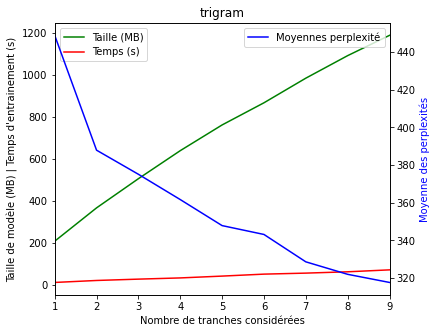

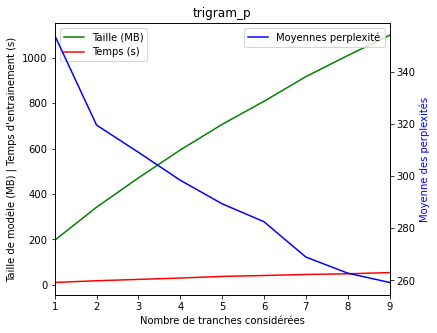

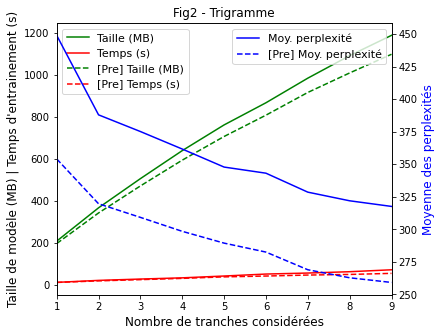

In [55]:
plot_curves(times_tr, sizes_tr, perplexities_tr,'trigram')
plot_curves(times_tr_p, sizes_tr_p, perplexities_tr_p,'trigram_p')
plot_curves_multiple(times_tr, sizes_tr, perplexities_tr,
                         times_tr_p, sizes_tr_p, perplexities_tr_p,
                         figname='Fig2 - Trigramme')